<font size="6">**Technical Indicators**</font>

In [1]:

import numpy as np
import seaborn as sns

from sklearn.model_selection import (TimeSeriesSplit, cross_validate)
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

running notebook configuration


In [4]:
from src.load_data import market_data
from src.mle import time_series as mle_ts
from src import utils

# Parameters

In [8]:
TAU_TARGET = 5
KFOLDS = 3

# Load Data

In [9]:
comm_df = market_data.read_mkt_data()[['brent']]
target = mle_ts.get_targets(y=comm_df[['brent']], tau=TAU_TARGET).rename(columns={'brent':'target'})

comm_df = comm_df.join(target, how='inner')

In [10]:
tscv = TimeSeriesSplit(n_splits=KFOLDS)
sp_tscv  = tscv.split(comm_df['target'])


In [11]:
from scipy.stats import spearmanr

def compute_spearman(y_true, y_pred):

    return spearmanr(y_true, y_pred, nan_policy='omit').correlation

In [12]:
from sklearn.metrics import fbeta_score, make_scorer
spearman_scorer = make_scorer(compute_spearman, greater_is_better=True)

# MACD

In [16]:
comm_df['brent_mave5'] = comm_df['brent'].rolling(5).mean()
comm_df['brent_mave20'] = comm_df['brent'].rolling(20).mean()
comm_df['x_brent_macd'] = comm_df['brent_mave5'] -comm_df['brent_mave20']

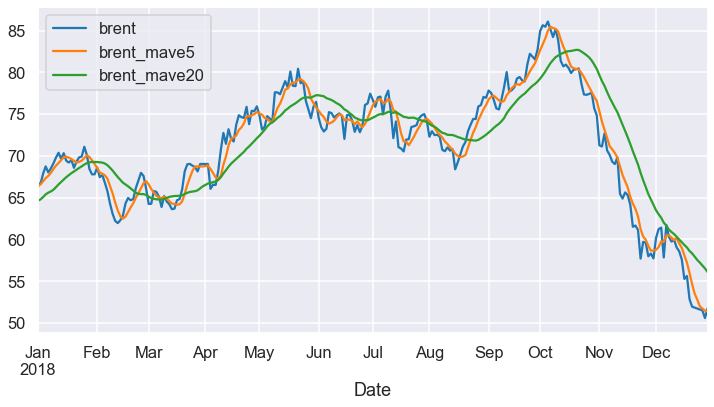

In [17]:
comm_df['2018'].plot(y=['brent', 'brent_mave5', 'brent_mave20'])
plt.show()

In [18]:
comm_df[['x_brent_macd', 'target']].corr('spearman')

,x_brent_macd,target
x_brent_macd,1.0000,0.0499
target,0.0499,1.0000


In [19]:
pd.crosstab(comm_df['x_brent_macd']>0, comm_df['target']>0, normalize=True)

target,False,True
x_brent_macd,,
False,0.1925,0.2028
True,0.2513,0.3534


In [20]:
compute_spearman(comm_df['x_brent_macd'] , comm_df['target'])

0.04985604466300076

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

from src.mle import time_series as mle_ts

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [22]:
lr = LinearRegression(fit_intercept=False)
pl_macd = Pipeline([('macd', mle_ts.MACD()), ('lr', lr)])

grid_macd = {'macd__short_tau': [3, 5, 10], 'macd__long_tau': [15, 20, 40, 60]}

macd_gcv = GridSearchCV(pl_macd, grid_macd, scoring=spearman_scorer, cv=tscv, n_jobs=-1)
macd_gcv.fit(comm_df[['brent']], comm_df['target'])

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=Pipeline(steps=[('macd', MACD()),
                                       ('lr',
                                        LinearRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'macd__long_tau': [15, 20, 40, 60],
                         'macd__short_tau': [3, 5, 10]},
             scoring=make_scorer(compute_spearman))

In [23]:
pd.DataFrame(macd_gcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_macd__long_tau,param_macd__short_tau,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.0431,0.0059,0.0132,0.0015,15,3,"{'macd__long_tau': 15, 'macd__short_tau': 3}",0.1672,-0.0756,-0.2131,-0.0405,0.1572,6
1,0.0279,0.0155,0.0160,0.0016,15,5,"{'macd__long_tau': 15, 'macd__short_tau': 5}",0.1981,-0.0816,-0.2113,-0.0316,0.1708,4
2,0.0153,0.0021,0.0135,0.0015,15,10,"{'macd__long_tau': 15, 'macd__short_tau': 10}",0.2139,-0.0867,-0.1832,-0.0186,0.1691,2
3,0.0154,0.0028,0.0131,0.0013,20,3,"{'macd__long_tau': 20, 'macd__short_tau': 3}",0.1556,-0.0832,-0.2523,-0.0600,0.1673,11
4,0.0130,0.0008,0.0107,0.0002,20,5,"{'macd__long_tau': 20, 'macd__short_tau': 5}",0.1688,-0.0892,-0.2499,-0.0567,0.1725,10
5,0.0152,0.0023,0.0113,0.0005,20,10,"{'macd__long_tau': 20, 'macd__short_tau': 10}",0.1700,-0.0917,-0.2234,-0.0483,0.1635,8
6,0.0140,0.0035,0.0140,0.0057,40,3,"{'macd__long_tau': 40, 'macd__short_tau': 3}",0.1077,-0.0672,0.2668,0.1025,0.1364,1
7,0.0131,0.0024,0.0110,0.0019,40,5,"{'macd__long_tau': 40, 'macd__short_tau': 5}",0.1192,-0.0710,-0.2588,-0.0702,0.1543,12
8,0.0123,0.0017,0.0108,0.0008,40,10,"{'macd__long_tau': 40, 'macd__short_tau': 10}",0.0999,-0.0466,-0.2218,-0.0562,0.1315,9
9,0.0133,0.0026,0.0100,0.0000,60,3,"{'macd__long_tau': 60, 'macd__short_tau': 3}",0.0802,-0.0388,-0.1726,-0.0437,0.1033,7


# Bollinger Bands

# Momentum